In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('/kaggle/input/political-sentiment/PS_train.csv')

In [3]:
df_train[:5]

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


In [4]:
df_val = pd.read_csv('/kaggle/input/political-sentiment/PS_dev.csv')

In [5]:
df_val[:5]

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [6]:
df_train = df_train.dropna()
df_val = df_val.dropna()

In [7]:
train_label_counts = df_train['labels'].value_counts()
print(train_label_counts)

labels
Opinionated          1361
Sarcastic             790
Neutral               637
Positive              575
Substantiated         412
Negative              406
None of the above     171
Name: count, dtype: int64


In [8]:
val_label_counts = df_val['labels'].value_counts()
print(val_label_counts)

labels
Opinionated          153
Sarcastic            115
Neutral               84
Positive              69
Substantiated         52
Negative              51
None of the above     20
Name: count, dtype: int64


In [9]:
df_merged = pd.concat([df_train, df_val], axis=0)

In [10]:
x_train = df_merged['content']
x_val = df_val['content']

In [11]:
replace_values = {
    "Opinionated" : 0,
    "Sarcastic" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Substantiated" : 4,
    "Negative" : 5,
    "None of the above" : 6
}

In [12]:
y_train = df_merged['labels'].replace(replace_values)
y_val = df_val['labels'].replace(replace_values)

<ipython-input-12-3800ea415c6b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df_merged['labels'].replace(replace_values)
<ipython-input-12-3800ea415c6b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = df_val['labels'].replace(replace_values)


In [13]:
y_train.value_counts()

labels
0    1514
1     905
2     721
3     644
4     464
5     457
6     191
Name: count, dtype: int64

In [14]:
y_val.value_counts()

labels
0    153
1    115
2     84
3     69
4     52
5     51
6     20
Name: count, dtype: int64

In [20]:
import tensorflow as tf
from keras_nlp.models import DebertaV3TextClassifierPreprocessor, DebertaV3TextClassifier
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model

In [57]:
preprocessor = DebertaV3TextClassifierPreprocessor.from_preset(
    "deberta_v3_base_multi",
    sequence_length=64,
    truncate="waterfall"
)

deberta = DebertaV3TextClassifier.from_preset(
    "deberta_v3_base_multi",
    num_classes=7,  
    preprocessor=preprocessor,
)
deberta.summary()

Preprocessor: "deberta_v3_text_classifier_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ deberta_v3_tokenizer (DebertaV3Tokenizer)                     │                      Vocab size: 250,102 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "deberta_v3_text_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ deberta_v3_backbone           │ (None, None, 768)         │     278,218,752 │ padding_mask[0][0],        │
│ (DebertaV3Backbone)           │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ deberta_v3_backbone[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │           5,383 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 278,814,727 (1.04 GB)

 Trainable params: 278,814,727 (1.04 GB)

 Non-trainable params: 0 (0.00 B)

In [58]:
deberta.backbone.trainable = False

In [59]:
model = Model(inputs=deberta.input, outputs=deberta.get_layer('logits').output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deberta_v3_backbone       │ (None, None, 768)      │    278,218,752 │ padding_mask[0][0],    │
│ (DebertaV3Backbone)       │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ deberta_v3_backbone[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooled_dropout (Dropout)  │ (None, 768)            │              0 │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooled_dense (Dense)      │ (None, 768)            │        590,592 │ pooled_dropout[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_dropout        │ (None, 768)            │              0 │ pooled_dense[0][0]     │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 7)              │          5,383 │ classifier_dropout[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 278,814,727 (1.04 GB)

 Trainable params: 595,975 (2.27 MB)

 Non-trainable params: 278,218,752 (1.04 GB)

In [60]:
history = model.fit(preprocessor(x_train), y_train, epochs=5, batch_size=32, validation_data=(preprocessor(x_val), y_val))

Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 78s 204ms/step - accuracy: 0.1926 - loss: 7.5896 - val_accuracy: 0.2114 - val_loss: 7.7651
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.1875 - loss: 7.8711 - val_accuracy: 0.2114 - val_loss: 7.7651
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.2191 - loss: 7.4525 - val_accuracy: 0.2445 - val_loss: 7.7651
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.2316 - loss: 7.9243 - val_accuracy: 0.2445 - val_loss: 7.7651
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.2335 - loss: 7.7910 - val_accuracy: 0.2445 - val_loss: 7.7651


In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

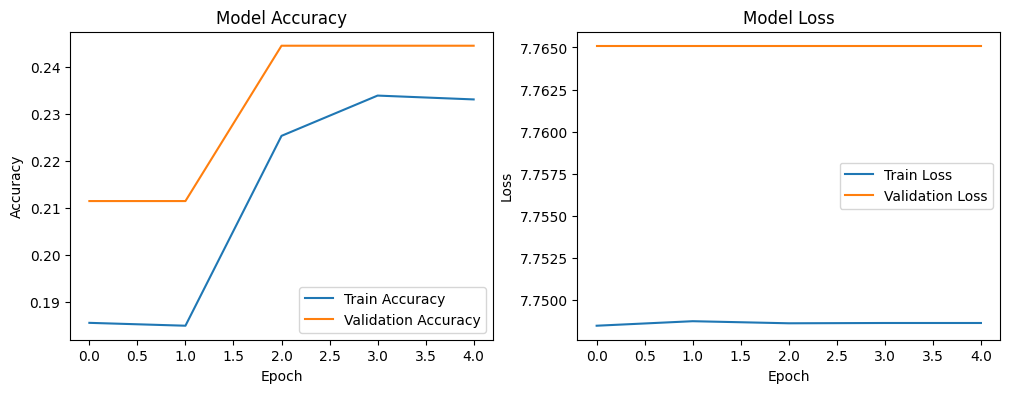

In [62]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

# Testing data

In [63]:
df_test = pd.read_csv('/kaggle/input/political-sentiment/PS_test.csv')

In [64]:
df_test[:5]

,Id,content,labels
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,Neutral
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,Negative
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,Substantiated
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",Positive
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,Positive


In [65]:
x_test = df_test['content']
y_test = df_test['labels'].replace(replace_values)

<ipython-input-65-fa0004870769>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = df_test['labels'].replace(replace_values)


In [66]:
pred = model.predict(preprocessor(x_test))

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step


In [68]:
y_pred = np.argmax(pred, axis=1)

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [70]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(7)]))

Accuracy: 0.2610
Precision: 0.0761
Recall: 0.1499
F1 Score: 0.0986

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.47      0.39       171
           1       0.21      0.58      0.30       106
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        25

    accuracy                           0.26       544
   macro avg       0.08      0.15      0.10       544
weighted avg       0.14      0.26      0.18       544



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

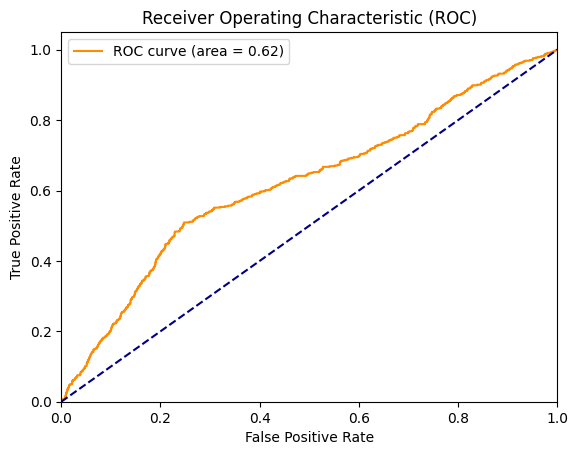

In [71]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

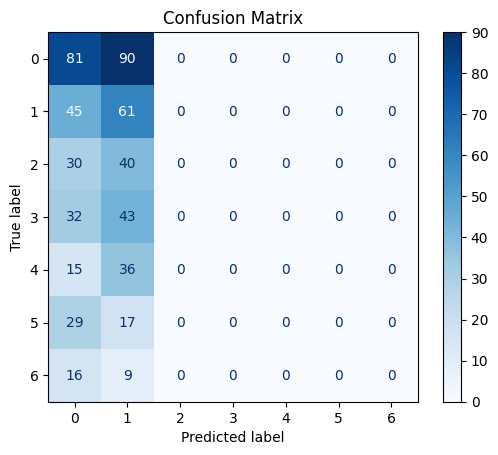

In [72]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()